# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size =  16 #experiment with the batch size
total_train_size = len(train_doc)
total_val_size = len(val_doc)
print(total_train_size,total_val_size)

663 100


In [75]:
import matplotlib.pyplot as plt
import os

# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

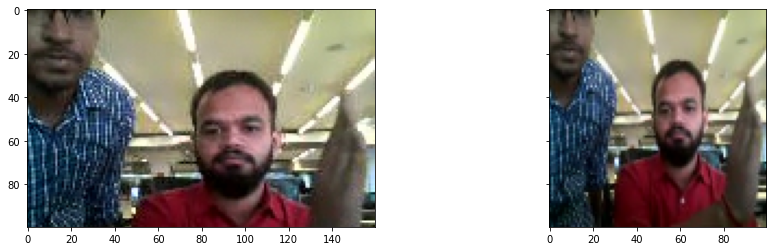

In [76]:
# Reading image of 160X120  to check the resized versin
image = imread('/home/datasets/Project_data/train/WIN_20180925_17_30_21_Pro_Right_Swipe_new/WIN_20180925_17_30_21_Pro_00004.png')
resized_image = resize(image,(100, 100))
plot_image([image,resized_image])

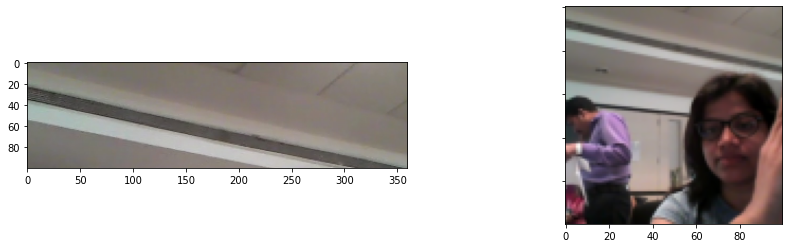

In [77]:
# Reading image of 360X360  to check the resized versin
image = imread('/home/datasets/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
resized_image = resize(image,(100, 100))
plot_image([image,resized_image])

In [4]:
img_size = 100
num_classes = 5
img_idx = range(0,30,7)
print(list(img_idx))
total_frames = len(img_idx)

[0, 7, 14, 21, 28]


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size,abilation = None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        if abilation is not None:
            folder_list = folder_list[:abilation]
        t = np.random.permutation(folder_list)
        total_num_data = len(t)
        num_batches =  (total_num_data//batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,total_frames,img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = resize(image, (img_size, img_size))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        remaining_folders =  (total_num_data % batch_size)
        batch = num_batches
        if remaining_folders > 0:
            batch_data = np.zeros((batch_size,total_frames,img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_folders): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = resize(image, (img_size, img_size))

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
print('# Total frames ',total_frames)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# Total frames  5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(total_frames,img_size,img_size,3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding="same" ))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding="same" ))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

In [82]:
# Overfit training data on small datase
optimiser = optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
abilation_training_size = 64
abilation_validation_size = 64

train_generator = generator(train_path, train_doc, abilation_training_size,abilation_training_size)
val_generator = generator(val_path, val_doc, abilation_validation_size,abilation_validation_size)

model.fit(train_generator, epochs=7,steps_per_epoch=1, validation_data=val_generator, validation_steps = 1)


Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/7
1/1 [==============================] - 5s 5s/step - loss: 2.4932 - categorical_accuracy: 0.1406 - val_loss: 47.3881 - val_categorical_accuracy: 0.1719
Epoch 2/7
1/1 [==============================] - 5s 5s/step - loss: 1.4476 - categorical_accuracy: 0.5000 - val_loss: 106.0811 - val_categorical_accuracy: 0.1719
Epoch 3/7
1/1 [==============================] - 5s 5s/step - loss: 1.1417 - categorical_accuracy: 0.6719 - val_loss: 108.0625 - val_categorical_accuracy: 0.1719
Epoch 4/7
1/1 [==============================] - 5s 5s/step - loss: 0.4241 - categorical_accuracy: 0.8438 - val_loss: 140.1448 - val_categorical_accuracy: 0.1719
Epoch 5/7
1/1 [==============================] - 5s 5s/step - loss: 0.3623 - categorical_accuracy: 0.8906 - val_loss: 205.2305 - val_categorical_accuracy: 0.1719
Epoch 6/7
1/1 [==============================] - 5s 5s/step - loss: 0.1912 - categorical_accuracy: 0.9531 - val_loss: 260.58

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [118]:
# model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',epoch = num_epochs)

# LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.0001)
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [100]:
def fitModel(model,batch_size):    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)

    optimiser = optimizers.SGD(learning_rate=0.01)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

    model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [89]:
fitModel(model,16)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 3, 98, 98, 16)     1312      
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 2, 49, 49, 16)     0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 2, 49, 49, 16)     64        
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 2, 49, 49, 32)     13856     
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 1, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 1, 25, 25, 32)     128       
_________________________________________________________________
dropout_24 (Dropout)         (None, 1, 25, 25, 32)    

### Building model using convo2d and RNN

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten,Dense,TimeDistributed,GRU,Conv2D

In [22]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))

In [23]:
for layer in resnet.layers[:-10]:
    layer.trainable=False

In [33]:
cnn = Sequential()
cnn.add(resnet)
cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'))
cnn.add(Conv2D(32, kernel_size=(2, 2), activation='relu', kernel_initializer='he_uniform'))
cnn.add(Flatten())

In [34]:
cnn.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 16)          294928    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 32)          2080      
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
Total params: 23,884,720
Trainable params: 4,762,672
Non-trainable params: 19,122,048
_________________________________________________________________


In [35]:
model = Sequential()
model.add(TimeDistributed(cnn,input_shape=(total_frames,img_size,img_size,3))) #4*256
model.add(GRU(16))
model.add(Dense(5,activation='softmax'))

In [36]:
# Overfit training data on small datase
optimiser = optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
abilation_training_size = 64
abilation_validation_size = 64

train_generator = generator(train_path, train_doc, abilation_training_size,abilation_training_size)
val_generator = generator(val_path, val_doc, abilation_validation_size,abilation_validation_size)

model.fit(train_generator, epochs=7,steps_per_epoch=1, validation_data=val_generator, validation_steps = 1)


Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/7
1/1 [==============================] - 7s 7s/step - loss: 1.6651 - categorical_accuracy: 0.1875 - val_loss: 1.7317 - val_categorical_accuracy: 0.1562
Epoch 2/7
1/1 [==============================] - 5s 5s/step - loss: 1.7559 - categorical_accuracy: 0.1875 - val_loss: 1.7383 - val_categorical_accuracy: 0.1562
Epoch 3/7
1/1 [==============================] - 5s 5s/step - loss: 1.7534 - categorical_accuracy: 0.1875 - val_loss: 1.7179 - val_categorical_accuracy: 0.1562
Epoch 4/7
1/1 [==============================] - 5s 5s/step - loss: 1.6708 - categorical_accuracy: 0.1875 - val_loss: 1.7797 - val_categorical_accuracy: 0.1562
Epoch 5/7
1/1 [==============================] - 5s 5s/step - loss: 1.6555 - categorical_accuracy: 0.1875 - val_loss: 1.8327 - val_categorical_accuracy: 0.2188
Epoch 6/7
1/1 [==============================] - 5s 5s/step - loss: 1.6426 - categorical_accuracy: 0.2812 - val_loss: 1.8102 - val_ca

In [117]:
fitModel(model,16)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 5, 5)              40499077  
_________________________________________________________________
gru_17 (GRU)                 (None, 5, 32)             3744      
_________________________________________________________________
gru_18 (GRU)                 (None, 5, 16)             2400      
_________________________________________________________________
gru_19 (GRU)                 (None, 8)                 624       
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 45        
Total params: 40,505,890
Trainable params: 21,383,330
Non-trainable params: 19,122,560
_________________________________________________________________
None
Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/20
42/42 [========

KeyboardInterrupt: 